In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)
     |████████████████████████████████| 215.7MB 72kB/s 
     |████████████████████████████████| 204kB 44.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130389 sha256=6ff6ac8bf9b0bd101cc9ab4cd0631ab163c85fbb97269b36f29dab93adbcf643
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
     |████████████████████████████████| 133kB 4.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sparknlp
spark = sparknlp.start() # start spark session
from sparknlp.annotator import *
## Pretrained Pipeline from Spark NLP
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import *
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline # Start Spark Session with Spark NLP

In [ ]:
# To use Spark and its API import the SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
# Create Spark Context
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pipeline_SA = PretrainedPipeline('analyze_sentiment', 'en')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [ ]:
from pyspark import SparkFiles
df = sqlContext.read.csv(SparkFiles.get('/content/drive/MyDrive/USvideos.csv'), header= True, inferSchema= True).limit(552)
df.columns

['video_id',
 'title',
 'channel_title',
 'category_id',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_total',
 'thumbnail_link',
 'date']

In [ ]:
df.show(40)

+-----------+--------------------+--------------------+-----------+--------------------+--------+------+--------+-------------+--------------------+-----+
|   video_id|               title|       channel_title|category_id|                tags|   views| likes|dislikes|comment_total|      thumbnail_link| date|
+-----------+--------------------+--------------------+-----------+--------------------+--------+------+--------+-------------+--------------------+-----+
|XpVt6Z1Gjjo|1 YEAR OF VLOGGIN...|    Logan Paul Vlogs|         24|logan paul vlog|l...| 4394029|320053|    5931|        46245|https://i.ytimg.c...|13.09|
|K4wEI5zhHB0|iPhone X — Introd...|               Apple|         28|Apple|iPhone 10|i...| 7860119|185853|   26679|            0|https://i.ytimg.c...|13.09|
|cLdxuaxaQwc|         My Response|           PewDiePie|         22|              [none]| 5845909|576597|   39774|       170708|https://i.ytimg.c...|13.09|
|WYYvHb03Eog|Apple iPhone X fi...|           The Verge|         28|app

In [ ]:
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_total: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- date: string (nullable = true)



In [ ]:
availableDf = df.where("likes > 0 AND dislikes > 0 AND comment_total > 0")
availableDf.show(40)

+-----------+--------------------+--------------------+-----------+--------------------+--------+------+--------+-------------+--------------------+-----+
|   video_id|               title|       channel_title|category_id|                tags|   views| likes|dislikes|comment_total|      thumbnail_link| date|
+-----------+--------------------+--------------------+-----------+--------------------+--------+------+--------+-------------+--------------------+-----+
|XpVt6Z1Gjjo|1 YEAR OF VLOGGIN...|    Logan Paul Vlogs|         24|logan paul vlog|l...| 4394029|320053|    5931|        46245|https://i.ytimg.c...|13.09|
|cLdxuaxaQwc|         My Response|           PewDiePie|         22|              [none]| 5845909|576597|   39774|       170708|https://i.ytimg.c...|13.09|
|WYYvHb03Eog|Apple iPhone X fi...|           The Verge|         28|apple iphone x ha...| 2642103| 24975|    4542|        12829|https://i.ytimg.c...|13.09|
|sjlHnJvXdQs|   iPhone X (parody)|          jacksfilms|         23|jac

In [ ]:
dropColumns = ['channel_title', 'category_id', 'tags', 'thumbnail_link']
dropDf = availableDf.drop(*dropColumns)

dropDf = dropDf.withColumn('views', dropDf['views'].cast('double'))
dropDf = dropDf.withColumn('likes', dropDf['likes'].cast('double'))
dropDf = dropDf.withColumn('dislikes', dropDf['dislikes'].cast('double'))
dropDf = dropDf.withColumn('date', dropDf['date'].cast('double'))

videoDataDF = dropDf.withColumn('comment_total', dropDf['comment_total'].cast('double'))


videoDataDF.show()

+-----------+--------------------+---------+--------+--------+-------------+-----+
|   video_id|               title|    views|   likes|dislikes|comment_total| date|
+-----------+--------------------+---------+--------+--------+-------------+-----+
|XpVt6Z1Gjjo|1 YEAR OF VLOGGIN...|4394029.0|320053.0|  5931.0|      46245.0|13.09|
|cLdxuaxaQwc|         My Response|5845909.0|576597.0| 39774.0|     170708.0|13.09|
|WYYvHb03Eog|Apple iPhone X fi...|2642103.0| 24975.0|  4542.0|      12829.0|13.09|
|sjlHnJvXdQs|   iPhone X (parody)|1168130.0| 96666.0|   568.0|       6666.0|13.09|
|cMKX2tE5Luk|The Disaster Arti...|1311445.0| 34507.0|   544.0|       3040.0|13.09|
|8wNr-NQImFg|The Check In: HUD...| 666169.0|  9985.0|   297.0|       1071.0|13.09|
|_HTXMhKWqnA|iPhone X Impressi...|1728614.0| 74062.0|  2180.0|      15297.0|13.09|
|_ANP3HR1jsM|ATTACKED BY A POL...|1338533.0| 69687.0|   678.0|       5643.0|13.09|
|zgLtEob6X-Q|Honest Trailers -...|1056891.0| 29943.0|   878.0|       4046.0|13.09|
|Ayb

In [ ]:
videoDataDF = videoDataDF.withColumn('likeRatio', videoDataDF.likes / (videoDataDF.likes + videoDataDF.dislikes))

videoDataDF.show()

+-----------+--------------------+---------+--------+--------+-------------+-----+------------------+
|   video_id|               title|    views|   likes|dislikes|comment_total| date|         likeRatio|
+-----------+--------------------+---------+--------+--------+-------------+-----+------------------+
|XpVt6Z1Gjjo|1 YEAR OF VLOGGIN...|4394029.0|320053.0|  5931.0|      46245.0|13.09|0.9818058555021105|
|cLdxuaxaQwc|         My Response|5845909.0|576597.0| 39774.0|     170708.0|13.09|0.9354706824299002|
|WYYvHb03Eog|Apple iPhone X fi...|2642103.0| 24975.0|  4542.0|      12829.0|13.09|0.8461225734322594|
|sjlHnJvXdQs|   iPhone X (parody)|1168130.0| 96666.0|   568.0|       6666.0|13.09|0.9941584219511693|
|cMKX2tE5Luk|The Disaster Arti...|1311445.0| 34507.0|   544.0|       3040.0|13.09| 0.984479758066817|
|8wNr-NQImFg|The Check In: HUD...| 666169.0|  9985.0|   297.0|       1071.0|13.09|0.9711145691499709|
|_HTXMhKWqnA|iPhone X Impressi...|1728614.0| 74062.0|  2180.0|      15297.0|13.09|

In [ ]:
videoDataDF.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- views: double (nullable = true)
 |-- likes: double (nullable = true)
 |-- dislikes: double (nullable = true)
 |-- comment_total: double (nullable = true)
 |-- date: double (nullable = true)
 |-- likeRatio: double (nullable = true)



# Comment Sentiment

In [ ]:
from pyspark.sql.functions import regexp_replace, trim, col
def removePunctuation(column):
  return trim(regexp_replace(column, '[^\sa-zA-Z]', '')).alias('transcriptSnippet')

In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))  # nltk stopwords list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [ ]:
df = sqlContext.read.csv(SparkFiles.get('/content/drive/MyDrive/comments/out0.csv'), header= True, inferSchema= True)
df.columns
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- likes: integer (nullable = true)
 |-- replies: integer (nullable = true)



In [ ]:
dropColumns = ['likes', 'replies']
commentsDF = df.drop(*dropColumns)

commentsDF.show()

+-----------+--------------------+
|   video_id|        comment_text|
+-----------+--------------------+
|XpVt6Z1Gjjo|Logan Paul it's y...|
|XpVt6Z1Gjjo|I've been followi...|
|XpVt6Z1Gjjo|Say hi to Kong an...|
|XpVt6Z1Gjjo| MY FAN . attendance|
|XpVt6Z1Gjjo|           trending |
|XpVt6Z1Gjjo|#1 on trending AY...|
|XpVt6Z1Gjjo|     The end though |
|XpVt6Z1Gjjo|#1 trending!!!!!!!!!|
|XpVt6Z1Gjjo|Happy one year vl...|
|XpVt6Z1Gjjo|You and your shit...|
|XpVt6Z1Gjjo|There should be a...|
|XpVt6Z1Gjjo|Dear Logan, I rea...|
|XpVt6Z1Gjjo|Honestly Evan is ...|
|XpVt6Z1Gjjo|Casey is still be...|
|XpVt6Z1Gjjo|aw geez rick this...|
|XpVt6Z1Gjjo|He happy cause he...|
|XpVt6Z1Gjjo|Ayyyyoooo Logang ...|
|XpVt6Z1Gjjo|Bro y didnt u giv...|
|XpVt6Z1Gjjo|It's been fun wat...|
|XpVt6Z1Gjjo|Made a lot of peo...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import regexp_replace, trim, col
def removePunctuation(column):
  return trim(regexp_replace(column, '[^\sa-zA-Z]', '')).alias('comment_text')

In [ ]:
# Get rid of punctuation
commentsDFNoPunc = commentsDF.select(col('video_id'), removePunctuation(col('comment_text')))
commentsDFNoPunc = commentsDFNoPunc.where('comment_text != ""')
commentsDFNoPunc.show()

+-----------+--------------------+
|   video_id|        comment_text|
+-----------+--------------------+
|XpVt6Z1Gjjo|Logan Paul its yo...|
|XpVt6Z1Gjjo|Ive been followin...|
|XpVt6Z1Gjjo|Say hi to Kong an...|
|XpVt6Z1Gjjo|  MY FAN  attendance|
|XpVt6Z1Gjjo|            trending|
|XpVt6Z1Gjjo|on trending AYYEEEEE|
|XpVt6Z1Gjjo|      The end though|
|XpVt6Z1Gjjo|            trending|
|XpVt6Z1Gjjo|Happy one year vl...|
|XpVt6Z1Gjjo|You and your shit...|
|XpVt6Z1Gjjo|There should be a...|
|XpVt6Z1Gjjo|Dear Logan I real...|
|XpVt6Z1Gjjo|Honestly Evan is ...|
|XpVt6Z1Gjjo|Casey is still be...|
|XpVt6Z1Gjjo|aw geez rick this...|
|XpVt6Z1Gjjo|He happy cause he...|
|XpVt6Z1Gjjo|Ayyyyoooo Logang ...|
|XpVt6Z1Gjjo|Bro y didnt u giv...|
|XpVt6Z1Gjjo|Its been fun watc...|
|XpVt6Z1Gjjo|Made a lot of peo...|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
commentsDfPandas = commentsDFNoPunc.toPandas()
commentsDfPandas['comment_text'] = commentsDfPandas['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))
print(commentsDfPandas)

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


          video_id                                  comment_text
0      XpVt6Z1Gjjo                         Logan Paul yo big day
1      XpVt6Z1Gjjo   Ive following start vine channel seen vlogs
2      XpVt6Z1Gjjo                          Say hi Kong maverick
3      XpVt6Z1Gjjo                             MY FAN attendance
4      XpVt6Z1Gjjo                                      trending
...            ...                                           ...
19574  zAtHxJvSczA         Maggie G looks like Sloth The Goonies
19575  zAtHxJvSczA                     DAFUQ aluminum foil dress
19576  zAtHxJvSczA                                    might jake
19577  zAtHxJvSczA           im sure Taylor many missing scarves
19578  zAtHxJvSczA  Maybe someone use scarf silence Taylor swift

[19579 rows x 2 columns]


In [ ]:
commentsNoStopDf = spark.createDataFrame(commentsDfPandas)

In [ ]:
comment_text = commentsNoStopDf.select('comment_text').rdd.map(lambda x: x['comment_text']).collect()

print(type(comment_text))

commentSentimentResults = pipeline_SA.annotate(comment_text)

<class 'list'>


In [ ]:
#print(commentSentimentResults)
sentimentRddComment = sc.parallelize(commentSentimentResults)
sentimentDFComment = sentimentRddComment.toDF()
sentimentDFComment = sentimentDFComment.select('document', 'sentiment')
sentimentDFComment = sentimentDFComment.withColumn('comment', sentimentDFComment.document[0])
sentimentDFComment = sentimentDFComment.withColumn('sentiment', sentimentDFComment.sentiment[0])
dropColumns = ['document']
sentimentDFComment = sentimentDFComment.drop(*dropColumns)
sentimentDFComment.show()
sentimentDFComment.printSchema()

/usr/local/lib/python3.6/dist-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+---------+--------------------+
|sentiment|             comment|
+---------+--------------------+
| negative|Logan Paul yo big...|
| positive|Ive following sta...|
| negative|Say hi Kong maverick|
| positive|   MY FAN attendance|
|       na|            trending|
|       na|   trending AYYEEEEE|
| positive|      The end though|
|       na|            trending|
| negative|Happy one year vl...|
| negative|You shit brother ...|
| negative|There mini Logan ...|
| positive|Dear Logan I real...|
| negative|Honestly Evan ann...|
| negative|Casey still bette...|
| negative|aw geez rick guy ...|
| negative|He happy cause movie|
| negative|Ayyyyoooo Logang ...|
| negative|Bro didnt u give ...|
| positive|Its fun watching ...|
| negative|Made lot people h...|
+---------+--------------------+
only showing top 20 rows

root
 |-- sentiment: string (nullable = true)
 |-- comment: string (nullable = true)



In [ ]:
commentSentimentDF = commentsNoStopDf.join(sentimentDFComment, commentsNoStopDf.comment_text == sentimentDFComment.comment)
commentSentimentDF = commentSentimentDF.drop('comment')
commentSentimentDF = commentSentimentDF.where('sentiment != "na"')
commentSentimentDF.show()

+-----------+--------------------+---------+
|   video_id|        comment_text|sentiment|
+-----------+--------------------+---------+
|9YyB6sQ4iwA|Am I person think...| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|eM_FR7I2Ttw|             Amazing| positive|
|AHrCI9eSJGQ|             Amazing| positive|
|AHrCI9eSJGQ|             Amazing| positive|
|AHrCI9eSJGQ|             Amazing| positive|
|AHrCI9eSJGQ|             Amazing| positive|
|AHrCI9eSJGQ|             Amazing| positive|
|AHrCI9eSJ

In [ ]:
commentSentimentDF.createOrReplaceTempView("commentSentimentDF")

commentSqlQuerySentimentCount = sqlContext.sql(
    'SELECT sum(case sentiment WHEN "positive" then 1 else 0 end) as PositiveCommentCount, sum(case sentiment WHEN "negative" then 1 else 0 end) as NegativeCommentCount, video_id as id FROM commentSentimentDF GROUP BY video_id')
commentSqlQuerySentimentCount.show()

+--------------------+--------------------+-----------+
|PositiveCommentCount|NegativeCommentCount|         id|
+--------------------+--------------------+-----------+
|                   8|                  16|mGqR9sgMIyA|
|                  76|                  33|a7Sf_H2cFdM|
|                 124|                 115|1L7JFN7tQLs|
|                  37|                  44|zTjcPeb2Gwg|
|                  11|                  12|k9bYO7uSnrg|
|                 107|                  76|WYYvHb03Eog|
|                  44|                  49|LTnl36-0-zU|
|                  77|                  32|oDIDZ9EmQfA|
|                  53|                  45|X7ld45pUueQ|
|                  61|                  45|J_e77K4n6Ts|
|                  49|                  48|DUFBEamEF0Q|
|                 119|                  90|vu_9muoxT50|
|                  97|                  30|REyxoxScrbU|
|                  43|                  43|_uLmn_Dba08|
|                  40|                  59|bnON1

In [ ]:
videoDataDF = videoDataDF.join(commentSqlQuerySentimentCount, commentSqlQuerySentimentCount.id == videoDataDF.video_id)
videoDataDF = videoDataDF.drop('id')

videoDataDF.show()

+-----------+--------------------+---------+-------+--------+-------------+-----+------------------+--------------------+--------------------+
|   video_id|               title|    views|  likes|dislikes|comment_total| date|         likeRatio|PositiveCommentCount|NegativeCommentCount|
+-----------+--------------------+---------+-------+--------+-------------+-----+------------------+--------------------+--------------------+
|mGqR9sgMIyA|Orlando braces fo...|  25652.0|   73.0|    11.0|         62.0|13.09|0.8690476190476191|                   8|                  16|
|a7Sf_H2cFdM|Drowning for Powe...| 971242.0|26435.0|   748.0|       1055.0|15.09|0.9724828017510945|                  76|                  33|
|a7Sf_H2cFdM|Drowning for Powe...| 947706.0|25968.0|   741.0|       1139.0|14.09|0.9722565427384028|                  76|                  33|
|a7Sf_H2cFdM|Drowning for Powe...| 917643.0|25456.0|   731.0|       1073.0|13.09|0.9720853858784894|                  76|                  33|

In [ ]:
videoDataDF = videoDataDF.withColumn('positiveCommentRatio', videoDataDF.PositiveCommentCount / (videoDataDF.PositiveCommentCount + videoDataDF.NegativeCommentCount))

videoDataDF.show()

+-----------+--------------------+---------+-------+--------+-------------+-----+------------------+--------------------+--------------------+--------------------+
|   video_id|               title|    views|  likes|dislikes|comment_total| date|         likeRatio|PositiveCommentCount|NegativeCommentCount|positiveCommentRatio|
+-----------+--------------------+---------+-------+--------+-------------+-----+------------------+--------------------+--------------------+--------------------+
|mGqR9sgMIyA|Orlando braces fo...|  25652.0|   73.0|    11.0|         62.0|13.09|0.8690476190476191|                   8|                  16|  0.3333333333333333|
|a7Sf_H2cFdM|Drowning for Powe...| 971242.0|26435.0|   748.0|       1055.0|15.09|0.9724828017510945|                  76|                  33|  0.6972477064220184|
|a7Sf_H2cFdM|Drowning for Powe...| 947706.0|25968.0|   741.0|       1139.0|14.09|0.9722565427384028|                  76|                  33|  0.6972477064220184|
|a7Sf_H2cFdM|Dro

# Analysis: Positive Comment Ratio

In [ ]:
visualizationDF = videoDataDF.toPandas()

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


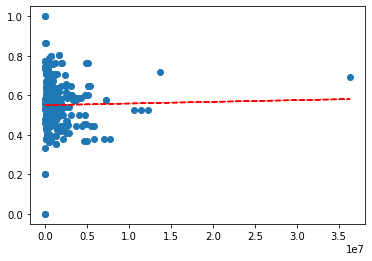

In [ ]:
#ax = visualizationDF.plot.scatter(x='views', y='positiveCommentRatio')



x = visualizationDF['views']
y = visualizationDF['positiveCommentRatio']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

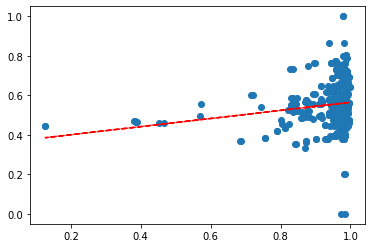

In [ ]:
#ax = visualizationDF.plot.scatter(x='likeRatio', y='positiveCommentRatio')

x = visualizationDF['likeRatio']
y = visualizationDF['positiveCommentRatio']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [ ]:
dropColumns = ['video_id', 'title', 'PositiveCommentCount', 'NegativeCommentCount']
ratioDF = videoDataDF.drop(*dropColumns)
ratioDF = ratioDF.where('views < 1000000')

In [ ]:
pandasVideoDataDf = ratioDF.toPandas()

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0e7efac18>]],
      dtype=object)

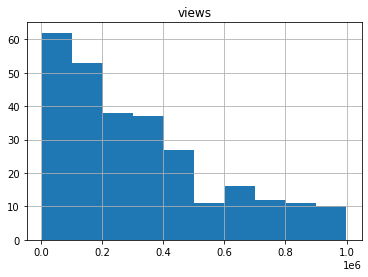

In [ ]:
pandasVideoDataDf.hist(column='views')

In [ ]:
print(pandasVideoDataDf)

        views    likes  dislikes  ...   date  likeRatio  positiveCommentRatio
0     25652.0     73.0      11.0  ...  13.09   0.869048              0.333333
1    971242.0  26435.0     748.0  ...  15.09   0.972483              0.697248
2    947706.0  25968.0     741.0  ...  14.09   0.972257              0.697248
3    917643.0  25456.0     731.0  ...  13.09   0.972085              0.697248
4    868054.0  24364.0     976.0  ...  15.09   0.961484              0.518828
..        ...      ...       ...  ...    ...        ...                   ...
272    8692.0    340.0      16.0  ...  13.09   0.955056              0.772727
273   19468.0     87.0       2.0  ...  14.09   0.977528              1.000000
274   19431.0     87.0       2.0  ...  13.09   0.977528              1.000000
275  829793.0   6501.0     386.0  ...  14.09   0.943952              0.626168
276  743947.0   6126.0     352.0  ...  13.09   0.945662              0.626168

[277 rows x 7 columns]


In [ ]:
# Use numpy to convert to arrays


# Labels are the values we want to predict
labels = np.array(pandasVideoDataDf['positiveCommentRatio'])

# Remove the labels from the features
# axis 1 refers to the columns
features = pandasVideoDataDf.drop('positiveCommentRatio', axis = 1)

# Saving feature names for later use
videoData_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
print(videoData_list)

['views', 'likes', 'dislikes', 'comment_total', 'date', 'likeRatio']


In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (207, 6)
Training Labels Shape: (207,)
Testing Features Shape: (70, 6)
Testing Labels Shape: (70,)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.08


In [ ]:
print(test_labels)

[0.7238806  0.73043478 0.67045455 0.53736655 0.46846847 0.5
 0.43548387 0.48863636 0.53488372 0.49586777 0.57       0.8
 0.70754717 0.53608247 0.77272727 0.55172414 0.52747253 0.40217391
 0.36842105 0.73275862 0.7109375  0.53191489 0.60416667 0.51041667
 1.         0.38095238 0.76282051 0.63953488 0.45679012 0.
 0.36363636 0.75       0.48387097 0.51612903 0.60606061 0.43333333
 0.42857143 0.55462185 0.51882845 0.66666667 0.5483871  0.57142857
 0.56666667 0.62626263 0.73043478 0.38095238 0.56937799 0.76282051
 0.40196078 0.47393365 0.75238095 0.55882353 0.64583333 0.5754717
 0.58333333 0.47826087 0.64583333 0.52727273 0.51041667 0.55102041
 0.55462185 0.58898305 0.5210084  0.54736842 0.50515464 0.55645161
 0.59130435 0.56666667 0.69465649 0.55882353]


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape[np.isfinite(mape)])

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 87.75 %.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = rf.estimators_[6]# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = rf.estimators_[6]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = videoData_list, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(videoData_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: likes                Importance: 0.28
Variable: comment_total        Importance: 0.26
Variable: likeRatio            Importance: 0.18
Variable: views                Importance: 0.15
Variable: dislikes             Importance: 0.12
Variable: date                 Importance: 0.01


In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)# Extract the most important features
important_indices = [videoData_list.index('comment_total'), videoData_list.index('dislikes'), videoData_list.index('likes'), videoData_list.index('likeRatio'), videoData_list.index('views')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]# Train the random forest
rf_most_important.fit(train_important, train_labels)# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'views.')
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.07 views.
Accuracy: 88.07 %.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


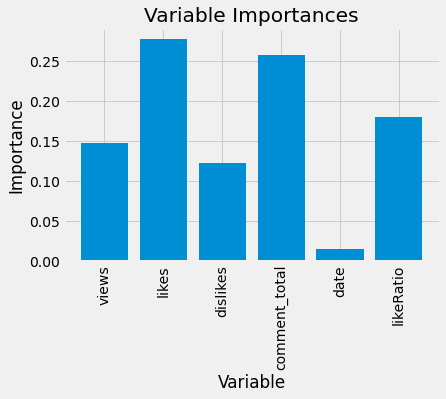

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline 

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, videoData_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Analysis: Views

In [ ]:
dropColumns = ['video_id', 'title']
viewsDF = videoDataDF.drop(*dropColumns)
viewsDF = viewsDF.where('views < 500000')

In [ ]:
pandasVideoDataDf = viewsDF.toPandas()

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [ ]:
# Labels are the values we want to predict
labels = np.array(pandasVideoDataDf['views'])

# Remove the labels from the features
# axis 1 refers to the columns
features = pandasVideoDataDf.drop('views', axis = 1)

# Saving feature names for later use
videoData_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (162, 8)
Training Labels Shape: (162,)
Testing Features Shape: (55, 8)
Testing Labels Shape: (55,)


In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 44495.11


In [ ]:
print(test_labels)

[ 59907.   8692.  96468. 447037. 433708. 273256.  16296. 406327.  48688.
  92656. 413029.  43199. 196016. 482681. 396083.  74494. 352284. 316616.
 220661. 216040.  54261. 150257.  91229. 396448. 416462. 431464. 352810.
 264911. 381229. 232505. 452477.  92783. 260164. 384682. 246389. 213820.
 108653. 342410. 279903.   7740. 229636. 122462. 310292. 111295. 222206.
 231371. 255967. 258781.  10892. 480279. 244433. 320880.  11830. 200970.
 165684.]


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape[np.isfinite(mape)])

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 65.43 %.


In [ ]:
tree = rf.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = videoData_list, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(videoData_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dislikes             Importance: 0.48
Variable: comment_total        Importance: 0.2
Variable: likes                Importance: 0.14
Variable: positiveCommentRatio Importance: 0.06
Variable: PositiveCommentCount Importance: 0.05
Variable: likeRatio            Importance: 0.04
Variable: NegativeCommentCount Importance: 0.03
Variable: date                 Importance: 0.01


In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)# Extract the two most important features

##CHANGE
important_indices = [videoData_list.index('likes'), videoData_list.index('dislikes'), videoData_list.index('comment_total')]
##CHANGE ^^^^^^^^^^^^^^^^^

train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]# Train the random forest
rf_most_important.fit(train_important, train_labels)# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'views.')
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 53942.4 views.
Accuracy: 62.32 %.


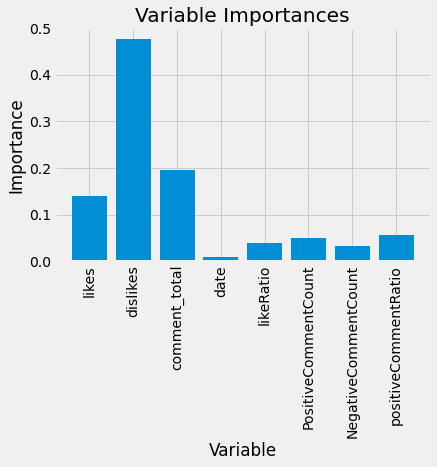

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline 

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, videoData_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Transcript Code - Not Used

In [ ]:
!pip install download-youtube-subtitle
import download_youtube_subtitle.common as common
import download_youtube_subtitle.main as download_youtube_subtitle

     |████████████████████████████████| 81kB 3.5MB/s 
  Created wheel for download-youtube-subtitle: filename=download_youtube_subtitle-1.0.2-cp36-none-any.whl size=8822 sha256=26b198d3ccc727d172aa0aa876be0b2f1c480a4cced8589f1acdcf6308bfccd4
  Stored in directory: /root/.cache/pip/wheels/16/56/f4/c7cb883841e067544d88f893bdc95f392c2c0ecc6e5226f305
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=3247db56b95cf53c1711962d862b24ed7f0fa377dcb2c256402ecc49f87cc559
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built download-youtube-subtitle fire


In [ ]:
import re
def get_valid_filename(s):
    s = str(s).strip().replace(' ', '')
    return re.sub(r'(?u)[^-\w.]', '', s)

In [ ]:
from pyspark.sql import Row
import json

transcriptDictionary = []

for entry in dropDf.collect():
  #print(entry['video_id'])
  !dl-youtube-cc {entry['video_id']} --translation='en' --to_json=True
  cleanName = get_valid_filename(entry['title'])
  #print('clean: ', cleanName)
  try:
    with open('%s.json' % cleanName) as json_file:
      transcript = json.load(json_file)

      #print(type(transcript))
      allText = ''
      for tEntry in transcript['translation']:
        #print('t:',)

      #print(allText)
        transcriptDictionary.append({'video_id': entry['video_id'], 'transcriptSnippet': tEntry['text']})
  except FileNotFoundError:
    allText = 'ERROR'
    transcriptDictionary.append({'video_id': entry['video_id'], 'transcript': 'ERROR'})

#print(transcriptDictionary)

INFO:  available caption(s) will be displayed as original text:
INFO:  ✔ #0. .ar      Arabic
INFO:  ⭕ #1. .en      English
INFO:  ⭕ #2. a.en     English+(auto-generated) automatically generated by youtube
INFO:  ⭕ #3. .pt      Portuguese
INFO:  ⭕ #4. .es      Spanish
INFO:  ⭕ #5. .ta      Tamil
INFO:  ⭕ #6. .tr      Turkish
INFO:  ✔ marks chosen one,  given by --caption_num in 0-index, default to 0
INFO:  Save to  1YEAROFVLOGGING--HOWLOGANPAULCHANGEDYOUTUBEFOREVER.json
INFO:  available caption(s) will be displayed as original text:
INFO:  ✔ #0. .sq      Albanian
INFO:  ⭕ #1. .ar      Arabic
INFO:  ⭕ #2. .az      Azerbaijani
INFO:  ⭕ #3. .bn      Bangla
INFO:  ⭕ #4. .bg      Bulgarian
INFO:  ⭕ #5. .ca      Catalan
INFO:  ⭕ #6. .chr     Cherokee
INFO:  ⭕ #7. .zh      Chinese
INFO:  ⭕ #8. .zh-TW   Chinese+(Taiwan)
INFO:  ⭕ #9. .hr      Croatian
INFO:  ⭕ #10. .cs      Czech
INFO:  ⭕ #11. .da      Danish
INFO:  ⭕ #12. .nl      Dutch
INFO:  ⭕ #13. .nl-NL   Dutch+(Netherlands)
INFO:  ⭕ #14. .

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([
                     StructField('video_id', StringType()),
                     StructField('transcriptSnippet', StringType())
])
tempRdd = sc.parallelize([transcriptDictionary])
transcriptDf = sqlContext.read.json(tempRdd, schema)
transcriptDf.show(40, False)

+-----------+------------------------------------------------------------------------+
|video_id   |transcriptSnippet                                                       |
+-----------+------------------------------------------------------------------------+
|XpVt6Z1Gjjo|                                                                        |
|XpVt6Z1Gjjo|adsdfsadfssdf                                                           |
|XpVt6Z1Gjjo| * Tuned auto [ __ ] *                                                  |
|XpVt6Z1Gjjo| Today is not an ordinary day, Logang                                   |
|XpVt6Z1Gjjo| And that's because today is a one-year concert for my fotografia videos|
|XpVt6Z1Gjjo| How beautiful a trip, man                                              |
|XpVt6Z1Gjjo| The right time to stay alive                                           |
|XpVt6Z1Gjjo| Gosh                                                                   |
|XpVt6Z1Gjjo| I'm excited                  

In [ ]:
# Get rid of rows that have transcript errors.
transcriptDf = transcriptDf.where("transcriptSnippet != 'ERROR' AND transcriptSnippet != ''")
transcriptDf.show()

+-----------+--------------------+
|   video_id|   transcriptSnippet|
+-----------+--------------------+
|XpVt6Z1Gjjo|       adsdfsadfssdf|
|XpVt6Z1Gjjo| * Tuned auto [ _...|
|XpVt6Z1Gjjo| Today is not an ...|
|XpVt6Z1Gjjo| And that's becau...|
|XpVt6Z1Gjjo| How beautiful a ...|
|XpVt6Z1Gjjo| The right time t...|
|XpVt6Z1Gjjo|                Gosh|
|XpVt6Z1Gjjo|         I'm excited|
|XpVt6Z1Gjjo| Okay, enough tal...|
|XpVt6Z1Gjjo| AYO Good morning...|
|XpVt6Z1Gjjo|       What appeared|
|XpVt6Z1Gjjo| It is the offici...|
|XpVt6Z1Gjjo|                WOAH|
|XpVt6Z1Gjjo|        You gud bro?|
|XpVt6Z1Gjjo| I've been vloggi...|
|XpVt6Z1Gjjo|            directly|
|XpVt6Z1Gjjo|        You gud bro?|
|XpVt6Z1Gjjo| One year of vlog...|
|XpVt6Z1Gjjo|      Each. one day.|
|XpVt6Z1Gjjo|                 Bro|
+-----------+--------------------+
only showing top 20 rows



In [ ]:
# Get rid of punctuation
transcriptDfNoPunc = transcriptDf.select(col('video_id'), removePunctuation(col('transcriptSnippet')))
transcriptDfNoPunc.show(40)

+-----------+--------------------+
|   video_id|        comment_text|
+-----------+--------------------+
|XpVt6Z1Gjjo|       adsdfsadfssdf|
|XpVt6Z1Gjjo|          Tuned auto|
|XpVt6Z1Gjjo|Today is not an o...|
|XpVt6Z1Gjjo|And thats because...|
|XpVt6Z1Gjjo|How beautiful a t...|
|XpVt6Z1Gjjo|The right time to...|
|XpVt6Z1Gjjo|                Gosh|
|XpVt6Z1Gjjo|          Im excited|
|XpVt6Z1Gjjo|Okay enough talki...|
|XpVt6Z1Gjjo|AYO Good morning ...|
|XpVt6Z1Gjjo|       What appeared|
|XpVt6Z1Gjjo|It is the officia...|
|XpVt6Z1Gjjo|                WOAH|
|XpVt6Z1Gjjo|         You gud bro|
|XpVt6Z1Gjjo|Ive been vlogging...|
|XpVt6Z1Gjjo|            directly|
|XpVt6Z1Gjjo|         You gud bro|
|XpVt6Z1Gjjo|One year of vlogging|
|XpVt6Z1Gjjo|        Each one day|
|XpVt6Z1Gjjo|                 Bro|
|XpVt6Z1Gjjo|What did you do w...|
|XpVt6Z1Gjjo|What do I do with...|
|XpVt6Z1Gjjo|Brendan Youre not...|
|XpVt6Z1Gjjo|            YeaaaAAh|
|XpVt6Z1Gjjo|What  Creak  you ...|
|XpVt6Z1Gjjo|Youre n

In [ ]:
transcriptDfPandas = transcriptDfNoPunc.toPandas()
transcriptDfPandas['transcriptSnippet'] = transcriptDfPandas['transcriptSnippet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))
print(transcriptDfPandas)

/usr/local/lib/python3.6/dist-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


KeyError: ignored

In [ ]:
transcriptNoStopDf = spark.createDataFrame(transcriptDfPandas)

transcriptNoStopDf.show(40)

In [ ]:
transcriptSnippet = transcriptNoStopDf.select('transcriptSnippet').rdd.map(lambda x: x['transcriptSnippet']).collect()
print(transcriptSnippet)
snippetSentimentResults = pipeline_SA.annotate(transcriptSnippet)


In [ ]:
print(snippetSentimentResults)
sentimentRdd = sc.parallelize(snippetSentimentResults)
sentimentDF = sentimentRdd.toDF()
sentimentDF = sentimentDF.select('document', 'sentiment')
sentimentDF = sentimentDF.withColumn('snippet', sentimentDF.document[0])
sentimentDF = sentimentDF.withColumn('sentiment', sentimentDF.sentiment[0])
dropColumns = ['document']
sentimentDF = sentimentDF.drop(*dropColumns)
sentimentDF.show()
sentimentDF.printSchema()

In [ ]:
transcriptSentimentDF = transcriptNoStopDf.join(sentimentDF, transcriptNoStopDf.transcriptSnippet == sentimentDF.snippet)
transcriptSentimentDF = transcriptSentimentDF.drop('snippet')
transcriptSentimentDF = transcriptSentimentDF.where('sentiment != "na"')
transcriptSentimentDF.show()

In [ ]:
transcriptSentimentDF.createOrReplaceTempView("transcriptSentimentDF")

sqlQuerySentimentCount = sqlContext.sql(
    'SELECT sum(case sentiment WHEN "positive" then 1 else 0 end) as PositiveSnippetCount, sum(case sentiment WHEN "negative" then 1 else 0 end) as NegativeSnippetCount, video_id as id FROM transcriptSentimentDF GROUP BY video_id')
sqlQuerySentimentCount.show()

In [ ]:
videoDataDF = videoDataDF.join(sqlQuerySentimentCount, sqlQuerySentimentCount.id == videoDataDF.video_id)
videoDataDF = videoDataDF.drop('id')

videoDataDF.show()

In [ ]:
videoDataDF = videoDataDF.withColumn('positiveSnippetRatio', videoDataDF.PositiveSnippetCount / (videoDataDF.PositiveSnippetCount + videoDataDF.NegativeSnippetCount))

videoDataDF.show()